In [1]:
import math
from numpy import concatenate
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import matplotlib.pyplot as plt
import numpy as np


In [8]:
def Iteration(Epochs):
    List_Epochs=[]
    for i in range(1,11):
        dataset = read_csv('Datos_Columna.csv', header=0, index_col=0,nrows=251)
        dataset = dataset[["Acetona %w","Etanol %w","Butanol %w","Reflujo","Carga térmica"]]
        values = dataset.values
        # convert series to supervised learning
        def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
            n_vars = 1 if type(data) is list else data.shape[1]
            df = DataFrame(data)
            cols, names = list(), list()
            # input sequence (t-n, ... t-1)
            for i in range(n_in, 0, -1):
                cols.append(df.shift(i))
                names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
            # forecast sequence (t, t+1, ... t+n)
            for i in range(0, n_out):
                cols.append(df.shift(-i))
                if i == 0:
                    names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
                else:
                    names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            # put it all together
            agg = concat(cols, axis=1)
            agg.columns = names
            # drop rows with NaN values
            if dropnan:
                agg.dropna(inplace=True)
            return agg


        # asegurarse de que todos los datos son tipo float
        values = values.astype('float32')
        # normalizar datos
        scaler = MinMaxScaler(feature_range=(0, 1))
        scaled = scaler.fit_transform(values)
        # especificar el número de horas de retrazo
        n_lag = 5
        n_features = 5
        # frame as supervised learning
        reframed = series_to_supervised(scaled, n_lag, 1)
        # Dividir en entrenamiento y prueba
        values = reframed.values
        n_train_index =61
        train = values[:n_train_index, :]
        test = values[n_train_index:, :]
        # Dividir en entradas y salidas
        #CHANGES HERE
        #split into input and outputs
        n_obs = n_lag * n_features
        train_X = train[:, :n_obs]
        train_y = train[:, -n_features:(-n_features+3)] #+2 because of indexing madness.
        test_X = test[:, :n_obs]
        test_y = test[:, -n_features:(-n_features+3)]

        train_X = train_X.reshape((train_X.shape[0], n_lag, n_features))
        test_X = test_X.reshape((test_X.shape[0], n_lag, n_features))

        #CAMBIOS AQUI

        #design network
        model = Sequential()
        model.add(LSTM(5,activation='linear', input_shape=(train_X.shape[1], train_X.shape[2])))
        model.add(Dense(3)) 
        model.compile(loss='mse', optimizer='rmsprop')

        #fit network
        history = model.fit(train_X, train_y, epochs=Epochs, batch_size=32, validation_data=(test_X, test_y), verbose=0, shuffle=False)

        #make a prediction
        y_hat = model.predict(test_X)

        #CHANGES HERE
        test_X = test_X.reshape((test_X.shape[0], n_lag*n_features))
        inv_yhat = concatenate((y_hat, test_X[:,-2:]), axis=1) #changed 7 to 6
        inv_yhat = scaler.inverse_transform(inv_yhat)
        inv_yhat = inv_yhat[:,0:3] #changed from 0 to 0:2. Should be first 2 columns that contain the predictions

        #CHANGES HERE
        #invert scaling for actual
        test_y = test_y.reshape((len(test_y),3)) #changed 1 to 2
        inv_y = concatenate((test_y, test_X[:,-2:]), axis=1) #changed 7 to 6
        inv_y = scaler.inverse_transform(inv_y)
        inv_y = inv_y[:,0:3] #changed from 0 to 0:2. Should be first 2 columns that contain the predictions.
        #CHANGES HERE
        #calculate RMSE - CHANGED to output RMSE for each variable.

        mse = mean_squared_error(inv_y[:,(0,1,2)], inv_yhat[:,(0,1,2)])
        List_Epochs.append(mse)
    return List_Epochs

In [10]:
Lista_Epochs_25 = Iteration(25)
PROM_Epochs_25 = sum(Lista_Epochs_25)/len(Lista_Epochs_25)
DESV_Epochs_25 = np.std(Lista_Epochs_25)
print('Lista_Epochs_25')
print(Lista_Epochs_25)
print('PROM_Epochs_25')
print(PROM_Epochs_25)
print('DESV_Epochs_25')
print(DESV_Epochs_25)

Lista_Epochs_25
[0.0006296551, 0.00023675343, 0.00064268894, 0.0002299004, 0.0007062798, 0.00059012795, 0.0001469123, 0.00082554715, 0.0005728978, 0.0001632645]
PROM_Epochs_25
0.000474402736290358
DESV_Epochs_25
0.00023935373


In [11]:
Lista_Epochs_50 = Iteration(50)
PROM_Epochs_50 = sum(Lista_Epochs_50)/len(Lista_Epochs_50)
DESV_Epochs_50 = np.std(Lista_Epochs_50)
print('Lista_Epochs_50')
print(Lista_Epochs_50)
print('PROM_Epochs_50')
print(PROM_Epochs_50)
print('DESV_Epochs_50')
print(DESV_Epochs_50)

Lista_Epochs_50
[0.00011826135, 9.1451606e-05, 0.00042551127, 0.00012785492, 0.00013881836, 0.00015428425, 0.00047214376, 0.0002541134, 6.663464e-05, 8.4375446e-05]
PROM_Epochs_50
0.0001933448998897802
DESV_Epochs_50
0.00013713508


In [12]:
Lista_Epochs_100 = Iteration(100)
PROM_Epochs_100 = sum(Lista_Epochs_100)/len(Lista_Epochs_100)
DESV_Epochs_100 = np.std(Lista_Epochs_100)
print('Lista_Epochs_100')
print(Lista_Epochs_100)
print('PROM_Epochs_100')
print(PROM_Epochs_100)
print('DESV_Epochs_100')
print(DESV_Epochs_100)

Lista_Epochs_100
[0.000119767654, 0.00010509603, 9.767821e-05, 8.725908e-05, 0.00015018795, 6.423628e-05, 4.3485936e-05, 0.00017691612, 0.00011449063, 8.08225e-05]
PROM_Epochs_100
0.00010399403799965512
DESV_Epochs_100
3.7296762e-05


In [13]:
Lista_Epochs_250 = Iteration(250)
PROM_Epochs_250 = sum(Lista_Epochs_250)/len(Lista_Epochs_250)
DESV_Epochs_250 = np.std(Lista_Epochs_250)
print('Lista_Epochs_250')
print(Lista_Epochs_250)
print('PROM_Epochs_250')
print(PROM_Epochs_250)
print('DESV_Epochs_250')
print(DESV_Epochs_250)

Lista_Epochs_250
[6.9871516e-05, 3.8331502e-05, 8.13704e-05, 3.003712e-05, 2.0027508e-05, 2.9353921e-05, 1.4923189e-05, 1.9352812e-05, 4.0355633e-05, 2.0407633e-05]
PROM_Epochs_250
3.6403123704076276e-05
DESV_Epochs_250
2.127878e-05


In [14]:
Lista_Epochs_500 = Iteration(500)
PROM_Epochs_500 = sum(Lista_Epochs_500)/len(Lista_Epochs_500)
DESV_Epochs_500 = np.std(Lista_Epochs_500)
print('Lista_Epochs_500')
print(Lista_Epochs_500)
print('PROM_Epochs_500')
print(PROM_Epochs_500)
print('DESV_Epochs_500')
print(DESV_Epochs_500)

Lista_Epochs_500
[6.6912166e-06, 1.2705419e-05, 1.1747317e-05, 1.6531583e-05, 7.621998e-06, 3.1342362e-05, 8.660777e-06, 1.9074434e-05, 1.562801e-05, 7.4571412e-06]
PROM_Epochs_500
1.3746025842920062e-05
DESV_Epochs_500
7.1209956e-06


In [15]:
Lista_Epochs_1000 = Iteration(1000)
PROM_Epochs_1000 = sum(Lista_Epochs_1000)/len(Lista_Epochs_1000)
DESV_Epochs_1000 = np.std(Lista_Epochs_1000)
print('Lista_Epochs_1000')
print(Lista_Epochs_1000)
print('PROM_Epochs_1000')
print(PROM_Epochs_1000)
print('DESV_Epochs_1000')
print(DESV_Epochs_1000)

Lista_Epochs_1000
[1.8751378e-05, 4.0049895e-06, 6.243212e-06, 5.9338813e-06, 3.6967847e-06, 1.0555826e-05, 2.0620531e-05, 2.903371e-06, 8.063912e-06, 6.847003e-06]
PROM_Epochs_1000
8.76208882800711e-06
DESV_Epochs_1000
5.871426e-06


In [16]:
Lista_Epochs_1500 = Iteration(1500)
PROM_Epochs_1500 = sum(Lista_Epochs_1500)/len(Lista_Epochs_1500)
DESV_Epochs_1500 = np.std(Lista_Epochs_1500)
print('Lista_Epochs_1500')
print(Lista_Epochs_1500)
print('PROM_Epochs_1500')
print(PROM_Epochs_1500)
print('DESV_Epochs_1500')
print(DESV_Epochs_1500)

Lista_Epochs_1500
[6.1325823e-06, 7.1896043e-06, 1.5195527e-05, 7.7123195e-06, 3.7503871e-06, 5.9937397e-06, 8.861556e-06, 8.082329e-06, 7.229662e-06, 6.651589e-06]
PROM_Epochs_1500
7.679929672121943e-06
DESV_Epochs_1500
2.8323645e-06


In [17]:
Lista_Epochs_2000 = Iteration(2000)
PROM_Epochs_2000 = sum(Lista_Epochs_2000)/len(Lista_Epochs_2000)
DESV_Epochs_2000 = np.std(Lista_Epochs_2000)
print('Lista_Epochs_2000')
print(Lista_Epochs_2000)
print('PROM_Epochs_2000')
print(PROM_Epochs_2000)
print('DESV_Epochs_2000')
print(DESV_Epochs_2000)

Lista_Epochs_2000
[5.660011e-06, 4.364519e-06, 3.4946606e-06, 5.864224e-06, 1.3043988e-05, 3.2420185e-06, 1.2109704e-05, 1.2872643e-05, 6.5228546e-06, 7.3454025e-06]
PROM_Epochs_2000
7.45200250094058e-06
DESV_Epochs_2000
3.6314163e-06


In [19]:
Lista_Epochs_3000 = Iteration(3000)
PROM_Epochs_3000 = sum(Lista_Epochs_3000)/len(Lista_Epochs_3000)
DESV_Epochs_3000 = np.std(Lista_Epochs_3000)
print('Lista_Epochs_3000')
print(Lista_Epochs_3000)
print('PROM_Epochs_3000')
print(PROM_Epochs_3000)
print('DESV_Epochs_3000')
print(DESV_Epochs_3000)

Lista_Epochs_3000
[2.9751538e-06, 6.4528635e-06, 5.981561e-06, 6.081546e-06, 7.971453e-06, 4.4234876e-06, 6.3712487e-06, 1.3598932e-05, 5.819283e-06, 8.551031e-06]
PROM_Epochs_3000
6.822655973337533e-06
DESV_Epochs_3000
2.709025e-06


In [20]:
Lista_Epochs_5000 = Iteration(5000)
PROM_Epochs_5000 = sum(Lista_Epochs_5000)/len(Lista_Epochs_5000)
DESV_Epochs_5000 = np.std(Lista_Epochs_5000)
print('Lista_Epochs_5000')
print(Lista_Epochs_5000)
print('PROM_Epochs_5000')
print(PROM_Epochs_5000)
print('DESV_Epochs_5000')
print(DESV_Epochs_5000)

Lista_Epochs_5000
[1.15545545e-05, 8.110251e-06, 3.1392617e-06, 1.0787694e-05, 7.169829e-06, 6.7328015e-06, 3.257348e-06, 1.3883594e-05, 5.6822414e-06, 1.1703305e-05]
PROM_Epochs_5000
8.20208799723332e-06
DESV_Epochs_5000
3.4946747e-06


In [ ]:
Lista_Epochs_10000 = Iteration(10000)
PROM_Epochs_10000 = sum(Lista_Epochs_10000)/len(Lista_Epochs_10000)
DESV_Epochs_10000 = np.std(Lista_Epochs_10000)
print('Lista_Epochs_10000')
print(Lista_Epochs_10000)
print('PROM_Epochs_10000')
print(PROM_Epochs_10000)
print('DESV_Epochs_10000s')
print(DESV_Epochs_5000)

In [24]:
PROM = [PROM_Epochs_25,PROM_Epochs_50,PROM_Epochs_100,PROM_Epochs_250,PROM_Epochs_500,PROM_Epochs_1000,PROM_Epochs_1500,PROM_Epochs_2000,PROM_Epochs_3000,PROM_Epochs_5000]
DESV = [DESV_Epochs_25,DESV_Epochs_50,DESV_Epochs_100,DESV_Epochs_250,DESV_Epochs_500,DESV_Epochs_1000,DESV_Epochs_1500,DESV_Epochs_2000,DESV_Epochs_3000,DESV_Epochs_5000]

In [2]:
PROM =[ 0.00010399403799965512, 3.6403123704076276e-05, 1.3746025842920062e-05, 8.76208882800711e-06, 7.679929672121943e-06, 7.45200250094058e-06, 6.822655973337533e-06, 8.20208799723332e-06]
DESV =[ 3.7296762e-05, 2.127878e-05, 7.1209956e-06, 5.871426e-06, 2.8323645e-06, 3.6314163e-06, 2.709025e-06, 3.4946747e-06]

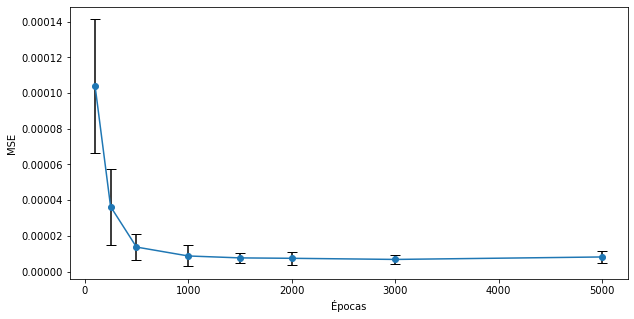

In [4]:
#Gráfico 
#plt.title('All - ONE HIDDEN- ADAM')
f =plt.figure(figsize = (10,5))
plt.xlabel('Épocas')
plt.ylabel('MSE')
X_Epochs=[100,250,500,1000,1500,2000,3000,5000]
MSE=PROM
yerror=DESV
#plt.plot(X_Neurons,MSE,'o')
plt.errorbar(X_Epochs,MSE, marker='o',yerr=yerror,ecolor="black",capsize=5)
plt.show()